In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode = True)

In [2]:
def calculate_vif_(X, thresh = 5):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped = True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('\nRemaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

## Pull Dataframes

In [3]:
from data_for_models import zori, df_clean, df_pred, df_change, df_pred_change

In [4]:
train_idx = np.random.choice(range(df_clean.shape[0]), round(df_clean.shape[0] * 0.75), replace = False)

In [5]:
train = df_clean.iloc[train_idx, :]
test = df_clean.iloc[list(set(range(df_clean.shape[0])) - set(train_idx)), :]

In [6]:
train_change_idx = np.random.choice(range(df_change.shape[0]), round(df_change.shape[0] * 0.75), replace = False)

In [7]:
train_change = df_change.iloc[train_change_idx, :]
test_change = df_change.iloc[list(set(range(df_change.shape[0])) - set(train_change_idx)), :]

## Multiple Linear Regression on ZORI

In [8]:
# Lasso penalization
scaler = StandardScaler()
data = train.iloc[:, 4:].copy()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns = data.columns)

lasso = Lasso(max_iter = 2500)

grid_para_lasso = [{"alpha": np.linspace(0.001, 0.1, 100)}]

grid_search_lasso = GridSearchCV(lasso, grid_para_lasso, cv = 5, n_jobs = -1, return_train_score = True)
grid_search_lasso.fit(scaled_data, train.iloc[:, 3])

GridSearchCV(cv=5, estimator=Lasso(max_iter=2500), n_jobs=-1,
             param_grid=[{'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ])}],
             return_train_score=True)

In [9]:
pd.DataFrame(grid_search_lasso.best_estimator_.coef_.reshape(-1, 1), index = train.iloc[:, 4:].columns, 
             columns = [f"Coefficient for alpha = {grid_search_lasso.best_params_['alpha']}"])

,Coefficient for alpha = 0.003
ZORI_lagged_1,542.527959
ZHVI_lagged_1,6.030721
HPI_lagged_2,-2.622139
AQI_lagged_1,1.923212
Population_lagged_2,-0.357936
Unemployment_lagged_1,4.841825
Percent Bachelors_lagged_2,2.527069
Permits_lagged_1,2.995618
Total_Households_lagged_2,-3.007653
Med_Income_lagged_2,-7.816260


In [10]:
# Drop Population_lagged_2 since coefficient is closest to 0
df_clean_MLR = df_clean.drop('Population_lagged_2', axis = 1)
df_pred_MLR = df_pred.drop('Population_lagged_2', axis = 1)
train_MLR = train.drop('Population_lagged_2', axis = 1)
test_MLR = test.drop('Population_lagged_2', axis = 1)

In [11]:
calculate_vif_(pd.concat([train_MLR.iloc[:, 4:].reset_index().drop('index', axis = 1), 
                          pd.DataFrame(np.array(1).repeat(train_MLR.shape[0]).reshape(-1, 1),
                                       columns = ['Constant'])], axis = 1),
               thresh = 5)

dropping 'Constant' at index: 18
dropping 'Salwrkr_lagged_2' at index: 13
dropping 'Gini_Index_lagged_2' at index: 16
dropping 'CommuteTime_lagged_2' at index: 12
dropping 'Med_Income_lagged_2' at index: 8
dropping 'PCE_lagged_1' at index: 8
dropping 'ZORI_lagged_1' at index: 0
dropping 'HPI_lagged_2' at index: 1
dropping 'Unemployment_lagged_1' at index: 2
dropping 'Percent Bachelors_lagged_2' at index: 2
dropping 'AQI_lagged_1' at index: 1
dropping 'Job Openings_lagged_1' at index: 4
dropping 'Govwrkr_lagged_2' at index: 4

Remaining variables:
Index(['ZHVI_lagged_1', 'Permits_lagged_1', 'Total_Households_lagged_2',
       'Rental Vacancy Rate_lagged_2', 'GRAPI_lagged_2', 'P_Density_lagged_2'],
      dtype='object')


,ZHVI_lagged_1,Permits_lagged_1,Total_Households_lagged_2,Rental Vacancy Rate_lagged_2,GRAPI_lagged_2,P_Density_lagged_2
0,784785.0,4380.0,1100858.0,3.6,748.8,721.053620
1,145279.0,5.0,106080.0,9.5,1.5,500.798725
2,139038.0,982.0,530213.0,3.3,338.3,1653.655687
3,409893.0,1291.0,282860.0,4.4,130.8,2591.963428
4,442738.0,4918.0,139104.0,5.9,1.6,253.646750
...,...,...,...,...,...,...
126041,184134.0,662.0,180787.0,1.6,1.4,1020.123254
126042,190264.0,170.0,740966.0,9.5,2.0,261.375347
126043,469494.0,3470.0,543560.0,4.2,1.9,1547.707528
126044,302061.0,6534.0,312298.0,5.8,117.0,999.244844


In [12]:
# Left with 6 final features after removing multicollinear features
df_clean_MLR = df_clean_MLR[['Year', 'Month', 'ZipCode', 'ZORI', 'ZHVI_lagged_1', 'Permits_lagged_1',
                             'Total_Households_lagged_2', 'Rental Vacancy Rate_lagged_2', 'P_Density_lagged_2',
                             'GRAPI_lagged_2']]
df_pred_MLR = df_pred_MLR[['Year', 'Month', 'ZipCode', 'ZHVI_lagged_1', 'Permits_lagged_1', 'Total_Households_lagged_2', 
                           'Rental Vacancy Rate_lagged_2', 'P_Density_lagged_2', 'GRAPI_lagged_2']]
train_MLR = train_MLR[['Year', 'Month', 'ZipCode', 'ZORI', 'ZHVI_lagged_1', 'Permits_lagged_1', 'Total_Households_lagged_2',
                       'Rental Vacancy Rate_lagged_2', 'P_Density_lagged_2', 'GRAPI_lagged_2']]
test_MLR = test_MLR[['Year', 'Month', 'ZipCode', 'ZORI', 'ZHVI_lagged_1', 'Permits_lagged_1', 'Total_Households_lagged_2',
             'Rental Vacancy Rate_lagged_2', 'P_Density_lagged_2', 'GRAPI_lagged_2']]

In [13]:
regression = LinearRegression()
regression.fit(train_MLR.iloc[:, 4:], train_MLR.iloc[:, 3])
regression.score(train_MLR.iloc[:, 4:], train_MLR.iloc[:, 3])

0.7143874617063244

In [14]:
r2_score(test_MLR.iloc[:, 3], regression.predict(test_MLR.iloc[:, 4:]))

0.7119582640825751

In [93]:
mean_squared_error(test_MLR.iloc[:, 3], regression.predict(test_MLR.iloc[:, 4:]), squared = False)

293.2793119149558

In [15]:
# Refit using the entire dataset
regression.fit(df_clean_MLR.iloc[:, 4:], df_clean_MLR.iloc[:, 3])

LinearRegression()

In [157]:
# Prediction on a randomly chosen ZipCode
zipcode = 85032
df_pred_zipcode = df_pred_MLR[df_pred_MLR['ZipCode'] == zipcode]
pred_MLR = regression.predict(df_pred_zipcode.iloc[:, 3:])

In [158]:
pred_MLR = pd.DataFrame({'Year': df_pred_zipcode['Year'], 'Month': df_pred_zipcode['Month'], 
                         'ZORI_MLR': pred_MLR}).reset_index().drop('index', axis = 1)
pred_MLR['Year_Month'] = pred_MLR['Year'].map(str) + '_' + pred_MLR['Month'].map(str)
pred_MLR = pred_MLR[['Year_Month', 'ZORI_MLR']]
pred_MLR['Year_Month'] = pd.to_datetime(pred_MLR['Year_Month'], format = '%Y_%m')

In [159]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

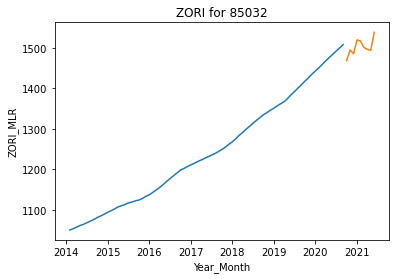

In [160]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_MLR', data = pred_MLR)
plt.title(f'ZORI for {zipcode}');

## Gradient Boosting Regressor on ZORI

In [20]:
gbm = ensemble.GradientBoostingRegressor()

In [21]:
grid_para_gbm = [{
    "loss": ['ls'], 
    "criterion": ['mse'],
    "n_estimators": [250, 500, 750], 
    "learning_rate": [0.01], 
    "subsample": [0.7],
    "max_depth": [2, 4, 6, 8, 10], 
    "max_features": [10]}]

grid_search_gbm = GridSearchCV(gbm, grid_para_gbm, cv = 5, n_jobs = -1, return_train_score = True)
grid_search_gbm.fit(train.iloc[:, 4:], train.iloc[:, 3])

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'learning_rate': [0.01],
                          'loss': ['ls'], 'max_depth': [2, 4, 6, 8, 10],
                          'max_features': [10], 'n_estimators': [250, 500, 750],
                          'subsample': [0.7]}],
             return_train_score=True)

In [22]:
pd.DataFrame.from_dict(grid_search_gbm.best_params_, orient = 'index', columns = ['hyperparameter'])

,hyperparameter
criterion,mse
learning_rate,0.01
loss,ls
max_depth,10
max_features,10
n_estimators,750
subsample,0.7


In [23]:
grid_search_gbm.cv_results_['mean_train_score'][0]

0.9457511191612481

In [24]:
grid_search_gbm.score(test.iloc[:, 4:], test.iloc[:, 3])

0.9984151791806368

In [94]:
mean_squared_error(test.iloc[:, 3], grid_search_gbm.predict(test.iloc[:, 4:]), squared = False)

17.3070716068167

In [25]:
# Refit using the entire dataset
grid_search_gbm.fit(df_clean.iloc[:, 4:], df_clean.iloc[:, 3])

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'learning_rate': [0.01],
                          'loss': ['ls'], 'max_depth': [2, 4, 6, 8, 10],
                          'max_features': [10], 'n_estimators': [250, 500, 750],
                          'subsample': [0.7]}],
             return_train_score=True)

In [161]:
# Prediction on a randomly chosen ZipCode
df_pred_zipcode = df_pred[df_pred['ZipCode'] == zipcode]
pred_GBM = grid_search_gbm.predict(df_pred_zipcode.iloc[:, 3:])

In [162]:
pred_GBM = pd.DataFrame({'Year': df_pred_zipcode['Year'], 'Month': df_pred_zipcode['Month'], 
                         'ZORI_GBM': pred_GBM}).reset_index().drop('index', axis = 1)
pred_GBM['Year_Month'] = pred_GBM['Year'].map(str) + '_' + pred_GBM['Month'].map(str)
pred_GBM = pred_GBM[['Year_Month', 'ZORI_GBM']]
pred_GBM['Year_Month'] = pd.to_datetime(pred_GBM['Year_Month'], format = '%Y_%m')

In [163]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

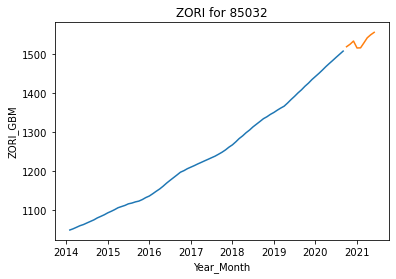

In [164]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_GBM', data = pred_GBM)
plt.title(f'ZORI for {zipcode}');

## Random Forest Regressor on ZORI

In [30]:
randomForest = ensemble.RandomForestRegressor()

In [31]:
grid_para_forest = [{
    "n_estimators": [300],
    "criterion": ["mse"],
    "min_samples_leaf": [50, 75, 100],
    "max_depth": [11, 12, 13], 
    "max_features": ['sqrt']}]

grid_search_forest = GridSearchCV(randomForest, grid_para_forest, cv = 5, n_jobs = -1, return_train_score = True)
grid_search_forest.fit(train.iloc[:, 4:], train.iloc[:, 3])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'max_depth': [11, 12, 13],
                          'max_features': ['sqrt'],
                          'min_samples_leaf': [50, 75, 100],
                          'n_estimators': [300]}],
             return_train_score=True)

In [32]:
pd.DataFrame.from_dict(grid_search_forest.best_params_, orient = 'index', columns = ['hyperparameter'])

,hyperparameter
criterion,mse
max_depth,13
max_features,sqrt
min_samples_leaf,50
n_estimators,300


In [33]:
grid_search_forest.cv_results_['mean_train_score'][0]

0.983811822031085

In [34]:
grid_search_forest.score(test.iloc[:, 4:], test.iloc[:, 3])

0.9861248263269438

In [95]:
mean_squared_error(test.iloc[:, 3], grid_search_forest.predict(test.iloc[:, 4:]), squared = False)

57.14455073551606

In [35]:
# Refit using the entire dataset
grid_search_forest.fit(df_clean.iloc[:, 4:], df_clean.iloc[:, 3])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'max_depth': [11, 12, 13],
                          'max_features': ['sqrt'],
                          'min_samples_leaf': [50, 75, 100],
                          'n_estimators': [300]}],
             return_train_score=True)

In [165]:
# Prediction on a randomly chosen ZipCode
df_pred_zipcode = df_pred[df_pred['ZipCode'] == zipcode]
pred_RF = grid_search_forest.predict(df_pred_zipcode.iloc[:, 3:])

In [166]:
pred_RF = pd.DataFrame({'Year': df_pred_zipcode['Year'], 'Month': df_pred_zipcode['Month'], 
                     'ZORI_RF': pred_RF}).reset_index().drop('index', axis = 1)
pred_RF['Year_Month'] = pred_RF['Year'].map(str) + '_' + pred_RF['Month'].map(str)
pred_RF = pred_RF[['Year_Month', 'ZORI_RF']]
pred_RF['Year_Month'] = pd.to_datetime(pred_RF['Year_Month'], format = '%Y_%m')

In [167]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

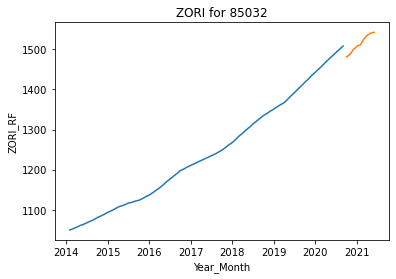

In [168]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_RF', data = pred_RF)
plt.title(f'ZORI for {zipcode}');

In [40]:
feature_importance = list(zip(df_pred_zipcode.columns[3:], grid_search_forest.best_estimator_.feature_importances_))
pd.DataFrame(sorted(feature_importance, key = lambda x: x[1], reverse = True), columns = ['feature', 'importance']).head(25)

,feature,importance
0,ZORI_lagged_1,0.485032
1,ZHVI_lagged_1,0.239569
2,HPI_lagged_2,0.056815
3,Job Openings_lagged_1,0.044352
4,Med_Income_lagged_2,0.042157
5,CommuteTime_lagged_2,0.033085
6,Rental Vacancy Rate_lagged_2,0.025515
7,Percent Bachelors_lagged_2,0.013780
8,Permits_lagged_1,0.012647
9,Population_lagged_2,0.009618


## Multiple Linear Regression on % Change in ZORI 

In [41]:
# Lasso penalization to assess feature significance
scaler = StandardScaler()
data = train_change.iloc[:, 4:].copy()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns = data.columns)

lasso_change = Lasso(max_iter = 2500)

grid_para_lasso_change = [{"alpha": np.linspace(1e-6, 1e-4, 100)}]

grid_search_lasso_change = GridSearchCV(lasso_change, grid_para_lasso_change, cv = 5, n_jobs = -1,
                                        return_train_score = True)
grid_search_lasso_change.fit(scaled_data, train_change.iloc[:, 3])

GridSearchCV(cv=5, estimator=Lasso(max_iter=2500), n_jobs=-1,
             param_grid=[{'alpha': array([1.0e-06, 2.0e-06, 3.0e-06, 4.0e-06, 5.0e-06, 6.0e-06, 7.0e-06,
       8.0e-06, 9.0e-06, 1.0e-05, 1.1e-05, 1.2e-05, 1.3e-05, 1.4e-05,
       1.5e-05, 1.6e-05, 1.7e-05, 1.8e-05, 1.9e-05, 2.0e-05, 2.1e-05,
       2.2e-05, 2.3e-05, 2.4e-05, 2.5e-05, 2.6e-05, 2.7e-05, 2.8e-05,
       2.9e-05, 3.0e-05, 3.1e-05, 3.2e-05, 3.3e-05...
       5.7e-05, 5.8e-05, 5.9e-05, 6.0e-05, 6.1e-05, 6.2e-05, 6.3e-05,
       6.4e-05, 6.5e-05, 6.6e-05, 6.7e-05, 6.8e-05, 6.9e-05, 7.0e-05,
       7.1e-05, 7.2e-05, 7.3e-05, 7.4e-05, 7.5e-05, 7.6e-05, 7.7e-05,
       7.8e-05, 7.9e-05, 8.0e-05, 8.1e-05, 8.2e-05, 8.3e-05, 8.4e-05,
       8.5e-05, 8.6e-05, 8.7e-05, 8.8e-05, 8.9e-05, 9.0e-05, 9.1e-05,
       9.2e-05, 9.3e-05, 9.4e-05, 9.5e-05, 9.6e-05, 9.7e-05, 9.8e-05,
       9.9e-05, 1.0e-04])}],
             return_train_score=True)

In [42]:
pd.DataFrame(grid_search_lasso_change.best_estimator_.coef_.reshape(-1, 1), index = train_change.iloc[:, 4:].columns, 
             columns = [f"Coefficient for alpha = {grid_search_lasso_change.best_params_['alpha']}"])

,Coefficient for alpha = 7.000000000000001e-06
ZHVI_lagged_1_delta,0.007295
HPI_lagged_2_delta,0.003028
AQI_lagged_1_delta,-0.000157
Population_lagged_2_delta,0.002918
Unemployment_lagged_1_delta,-0.002092
Percent Bachelors_lagged_2_delta,-0.000225
Permits_lagged_1_delta,-0.000259
Total_Households_lagged_2_delta,-0.000378
Med_Income_lagged_2_delta,0.000046
PCE_lagged_1_delta,-0.001623


In [43]:
# Drop Gini_Index_lagged_2_delta since coefficient is closest to 0
df_change_MLR = df_change.drop('Gini_Index_lagged_2_delta', axis = 1)
df_pred_change_MLR = df_pred_change.drop('Gini_Index_lagged_2_delta', axis = 1)
train_change_MLR = train_change.drop('Gini_Index_lagged_2_delta', axis = 1)
test_change_MLR = test_change.drop('Gini_Index_lagged_2_delta', axis = 1)

In [44]:
calculate_vif_(pd.concat([train_change_MLR.iloc[:, 4:].reset_index().drop('index', axis = 1), 
                          pd.DataFrame(np.array(1).repeat(train_change_MLR.shape[0]).reshape(-1, 1),
                                       columns = ['Constant'])], axis = 1),
               thresh = 5)

dropping 'Constant' at index: 17

Remaining variables:
Index(['ZHVI_lagged_1_delta', 'HPI_lagged_2_delta', 'AQI_lagged_1_delta',
       'Population_lagged_2_delta', 'Unemployment_lagged_1_delta',
       'Percent Bachelors_lagged_2_delta', 'Permits_lagged_1_delta',
       'Total_Households_lagged_2_delta', 'Med_Income_lagged_2_delta',
       'PCE_lagged_1_delta', 'Rental Vacancy Rate_lagged_2_delta',
       'Job Openings_lagged_1_delta', 'CommuteTime_lagged_2_delta',
       'Salwrkr_lagged_2_delta', 'Govwrkr_lagged_2_delta',
       'GRAPI_lagged_2_delta', 'P_Density_lagged_2_delta'],
      dtype='object')


,ZHVI_lagged_1_delta,HPI_lagged_2_delta,AQI_lagged_1_delta,Population_lagged_2_delta,Unemployment_lagged_1_delta,Percent Bachelors_lagged_2_delta,Permits_lagged_1_delta,Total_Households_lagged_2_delta,Med_Income_lagged_2_delta,PCE_lagged_1_delta,Rental Vacancy Rate_lagged_2_delta,Job Openings_lagged_1_delta,CommuteTime_lagged_2_delta,Salwrkr_lagged_2_delta,Govwrkr_lagged_2_delta,GRAPI_lagged_2_delta,P_Density_lagged_2_delta
0,0.033259,0.074654,0.212027,0.015318,0.111111,-0.037209,17.250000,0.020514,0.016389,0.219622,-0.269663,-0.202703,0.000000,-0.017544,0.020619,-0.991444,0.015318
1,0.086675,0.081949,0.025641,0.032263,-0.076923,0.109489,0.362010,0.074964,0.065987,0.559821,-0.112245,0.096463,0.038732,-0.011016,0.089431,-0.967532,0.032263
2,0.138092,0.216548,-0.145206,0.006688,0.114286,0.026415,-0.627273,-0.002573,0.035082,-0.080298,0.404255,-0.068376,0.003745,0.010333,-0.062500,0.000000,0.006688
3,0.066669,0.066336,0.063850,0.010216,-0.117647,-0.017668,-0.330000,0.005164,0.027586,0.222897,-0.161290,0.359649,0.046025,0.004745,-0.008696,0.000000,0.010216
4,0.077736,0.057268,0.474377,0.015502,-0.078947,-0.016854,1.064906,0.007152,0.018136,0.392767,0.120482,0.208068,-0.011719,0.000000,-0.050725,0.000000,0.015502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128276,0.050774,0.060113,0.147307,0.002524,-0.041667,0.029268,-0.330379,0.001707,0.059800,0.355939,0.137931,0.146893,0.003165,0.000000,-0.008772,0.000000,0.002524
128277,0.027456,0.031789,0.082251,0.011016,-0.022727,0.023256,-0.004862,0.001452,0.037191,0.203475,0.400000,0.132353,-0.003155,0.009602,-0.014151,-0.048969,0.011016
128278,0.132206,0.098594,0.298196,-0.003183,-0.134615,0.014851,0.206074,0.003794,0.037271,-0.101121,-0.033333,0.041908,0.022654,-0.005019,0.055556,0.000000,-0.003183
128279,0.103019,0.178695,0.057464,0.017461,-0.101449,-0.029586,0.081373,0.005237,0.024169,-0.308396,-0.069444,0.155235,0.041379,-0.002427,-0.030000,-0.005733,0.017461


In [45]:
# No multicollinearity so all features stay

In [46]:
regression_change = LinearRegression()
regression_change.fit(train_change_MLR.iloc[:, 4:], train_change_MLR.iloc[:, 3])
regression_change.score(train_change_MLR.iloc[:, 4:], train_change_MLR.iloc[:, 3])

0.17422407791708372

In [47]:
r2_score(test_change_MLR.iloc[:, 3], regression_change.predict(test_change_MLR.iloc[:, 4:]))

0.17939519400351267

In [96]:
mean_squared_error(test_change_MLR.iloc[:, 3], regression_change.predict(test_change_MLR.iloc[:, 4:]), squared = False)

0.025061745219316922

In [48]:
# Refit using the entire dataset
regression_change.fit(df_change_MLR.iloc[:, 4:], df_change_MLR.iloc[:, 3])

LinearRegression()

In [169]:
# Prediction on a randomly chosen ZipCode
df_pred_change_zipcode = df_pred_change_MLR[df_pred_change_MLR['ZipCode'] == zipcode]
pred_change_MLR = regression_change.predict(df_pred_change_zipcode.iloc[:, 3:])

In [170]:
pred_change_MLR = pd.DataFrame({'Year': df_pred_change_zipcode['Year'], 'Month': df_pred_change_zipcode['Month'], 
                     'ZORI_MLR': pred_change_MLR}).reset_index().drop('index', axis = 1)
pred_change_MLR['Year_Month'] = pred_change_MLR['Year'].map(str) + '_' + pred_change_MLR['Month'].map(str)
pred_change_MLR = pred_change_MLR[['Year_Month', 'ZORI_MLR']]
pred_change_MLR['Year_Month'] = pd.to_datetime(pred_change_MLR['Year_Month'], format = '%Y_%m')

In [171]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

In [172]:
pred_change_MLR.loc[:, 'ZORI_MLR'] = np.array(actual[actual['Year_Month'].isin(pred_change_MLR['Year_Month'].map(lambda date:\
                                     date - relativedelta(months = 12)))]['ZORI']) * np.array((1 +\
                                     pred_change_MLR['ZORI_MLR']))

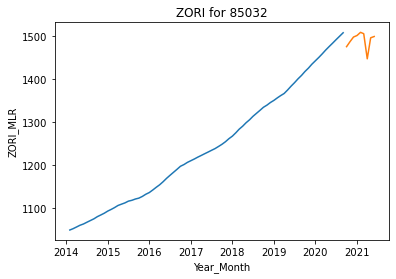

In [173]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_MLR', data = pred_change_MLR)
plt.title(f'ZORI for {zipcode}');

## Gradient Boosting Regressor on % Change in ZORI

In [54]:
gbm_change = ensemble.GradientBoostingRegressor()

In [55]:
grid_para_gbm_change = [{
    "loss": ['ls'], 
    "criterion": ['mse'],
    "n_estimators": [250, 500, 750],
    "learning_rate": [0.01], 
    "subsample": [0.7],
    "max_depth": [2, 4, 6, 8, 10], 
    "max_features": [10]}]

grid_search_gbm_change = GridSearchCV(gbm_change, grid_para_gbm_change, cv = 5, n_jobs = -1, return_train_score = True)
grid_search_gbm_change.fit(train_change.iloc[:, 4:], train_change.iloc[:, 3])

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'learning_rate': [0.01],
                          'loss': ['ls'], 'max_depth': [2, 4, 6, 8, 10],
                          'max_features': [10], 'n_estimators': [250, 500, 750],
                          'subsample': [0.7]}],
             return_train_score=True)

In [56]:
pd.DataFrame.from_dict(grid_search_gbm_change.best_params_, orient = 'index', columns = ['hyperparameter'])

,hyperparameter
criterion,mse
learning_rate,0.01
loss,ls
max_depth,10
max_features,10
n_estimators,750
subsample,0.7


In [57]:
grid_search_gbm_change.cv_results_['mean_train_score'][0]

0.19468554812626554

In [58]:
grid_search_gbm_change.score(test_change.iloc[:, 4:], test_change.iloc[:, 3])

0.6155905544948749

In [97]:
mean_squared_error(test_change.iloc[:, 3], grid_search_gbm_change.predict(test_change.iloc[:, 4:]), squared = False)

0.015233533744449556

In [174]:
# Refit using the entire dataset
grid_search_gbm_change.fit(df_change.iloc[:, 4:], df_change.iloc[:, 3])

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'learning_rate': [0.01],
                          'loss': ['ls'], 'max_depth': [2, 4, 6, 8, 10],
                          'max_features': [10], 'n_estimators': [250, 500, 750],
                          'subsample': [0.7]}],
             return_train_score=True)

In [176]:
# Prediction on a randomly chosen ZipCode
df_pred_change_zipcode = df_pred_change[df_pred_change['ZipCode'] == zipcode]
pred_change_GBM = grid_search_gbm_change.predict(df_pred_change_zipcode.iloc[:, 3:])

In [177]:
pred_change_GBM = pd.DataFrame({'Year': df_pred_change_zipcode['Year'], 'Month': df_pred_change_zipcode['Month'], 
                                'ZORI_GBM': pred_change_GBM}).reset_index().drop('index', axis = 1)
pred_change_GBM['Year_Month'] = pred_change_GBM['Year'].map(str) + '_' + pred_change_GBM['Month'].map(str)
pred_change_GBM = pred_change_GBM[['Year_Month', 'ZORI_GBM']]
pred_change_GBM['Year_Month'] = pd.to_datetime(pred_change_GBM['Year_Month'], format = '%Y_%m')

In [178]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

In [179]:
pred_change_GBM.loc[:, 'ZORI_GBM'] = np.array(actual[actual['Year_Month'].isin(pred_change_GBM['Year_Month'].map(lambda date:\
                                     date - relativedelta(months = 12)))]['ZORI']) * np.array((1 + pred_change_GBM['ZORI_GBM']))

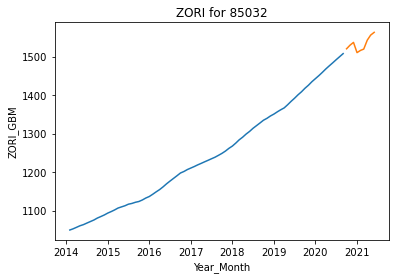

In [180]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_GBM', data = pred_change_GBM)
plt.title(f'ZORI for {zipcode}');

## Random Forest Regressor on % Change in ZORI

In [65]:
randomForest_change = ensemble.RandomForestRegressor()

In [66]:
grid_para_forest_change = [{
    "n_estimators": [300],
    "criterion": ["mse"],
    "min_samples_leaf": [40, 50, 60],
    "max_depth": [10, 11, 12],
    "max_features": ['sqrt']}]

grid_search_forest_change = GridSearchCV(randomForest_change, grid_para_forest_change, cv = 5, n_jobs = -1,
                                         return_train_score = True)
grid_search_forest_change.fit(train_change.iloc[:, 4:], train_change.iloc[:, 3])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'max_depth': [10, 11, 12],
                          'max_features': ['sqrt'],
                          'min_samples_leaf': [40, 50, 60],
                          'n_estimators': [300]}],
             return_train_score=True)

In [67]:
pd.DataFrame.from_dict(grid_search_forest_change.best_params_, orient = 'index', columns = ['hyperparameter'])

,hyperparameter
criterion,mse
max_depth,12
max_features,sqrt
min_samples_leaf,40
n_estimators,300


In [68]:
grid_search_forest_change.cv_results_['mean_train_score'][0]

0.43223748980450444

In [69]:
grid_search_forest_change.score(test_change.iloc[:, 4:], test_change.iloc[:, 3])

0.46614326525710004

In [100]:
mean_squared_error(test_change.iloc[:, 3], grid_search_forest_change.predict(test_change.iloc[:, 4:]), squared = False)

0.01971322620230723

In [70]:
# Refit using the entire dataset
grid_search_forest_change.fit(df_change.iloc[:, 4:], df_change.iloc[:, 3])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'max_depth': [10, 11, 12],
                          'max_features': ['sqrt'],
                          'min_samples_leaf': [40, 50, 60],
                          'n_estimators': [300]}],
             return_train_score=True)

In [181]:
# Prediction on a randomly chosen ZipCode
df_pred_change_zipcode = df_pred_change[df_pred_change['ZipCode'] == zipcode]
pred_change_RF = grid_search_forest_change.predict(df_pred_change_zipcode.iloc[:, 3:])

In [182]:
pred_change_RF = pd.DataFrame({'Year': df_pred_change_zipcode['Year'], 'Month': df_pred_change_zipcode['Month'], 
                     'ZORI_RF': pred_change_RF}).reset_index().drop('index', axis = 1)
pred_change_RF['Year_Month'] = pred_change_RF['Year'].map(str) + '_' + pred_change_RF['Month'].map(str)
pred_change_RF = pred_change_RF[['Year_Month', 'ZORI_RF']]
pred_change_RF['Year_Month'] = pd.to_datetime(pred_change_RF['Year_Month'], format = '%Y_%m')

In [183]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

In [184]:
pred_change_RF.loc[:, 'ZORI_RF'] = np.array(actual[actual['Year_Month'].isin(pred_change_RF['Year_Month'].map(lambda date:\
                                   date - relativedelta(months = 12)))]['ZORI']) * np.array((1 + pred_change_RF['ZORI_RF']))

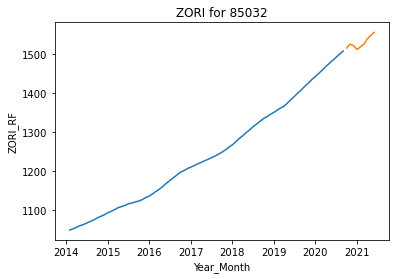

In [185]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_RF', data = pred_change_RF)
plt.title(f'ZORI for {zipcode}');

## Aggregate Prediction 

In [186]:
pred = pd.DataFrame({'Year_Month': pred_MLR['Year_Month'], 'ZORI':\
            ((pred_MLR['ZORI_MLR'] + pred_RF['ZORI_RF'] + pred_GBM['ZORI_GBM'] + pred_change_MLR['ZORI_MLR'] +\
              pred_change_RF['ZORI_RF'] + pred_change_GBM['ZORI_GBM']) / 6)})

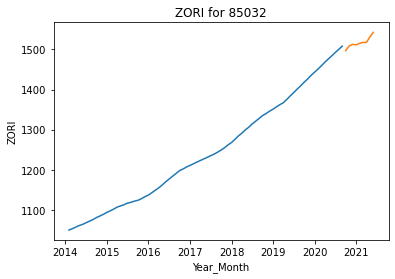

In [187]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = pred)
plt.title(f'ZORI for {zipcode}');

In [229]:
df_pred['ZipCode'].unique()[:100]

array([60657, 60614, 77449, 77084, 79936, 60640, 11226, 78660, 37013,
       60647, 11375, 90250, 37211, 77573, 60618, 77584, 28269, 77433,
       30349, 79912, 75052, 73099, 90046, 77429, 78245, 60613, 30044,
       28277, 60625, 30043, 11212, 10463, 60629, 11209, 30096, 98052,
       30024, 78704, 77077, 85032, 77379, 21234, 33160, 34787, 75243,
       11207, 94501,  2169, 33411, 60619, 78745, 94110, 33025, 75067,
       90034, 80134, 95630, 44107, 66062, 44035, 85281, 11377, 90805,
        7302, 85710, 92683, 85225, 11234, 30281, 37075, 11355, 10314,
       19143, 91709, 11215, 60617, 32210, 90026, 76063, 91910, 27587,
       93722, 97229,  6010, 76028, 33908, 43123, 75056, 89108, 85308,
       78240, 33024, 98012, 30318, 44060, 95608, 33647, 92677, 44256,
        2148], dtype=int64)

In [230]:
# County prediction
zipcode = 75056
county = search.by_zipcode(zipcode).values()[5][:-7]
state = search.by_zipcode(zipcode).values()[6]
print(county + ', ' + state)

Denton, TX


In [231]:
df_county_temp = pd.merge(df_pred, zori[['ZipCode', 'County', 'State']].drop_duplicates(), on = 'ZipCode')
df_county_temp_MLR = pd.merge(df_pred_MLR, zori[['ZipCode', 'County', 'State']].drop_duplicates(), on = 'ZipCode')
df_county_change_temp = pd.merge(df_pred_change, zori[['ZipCode', 'County', 'State']].drop_duplicates(), on = 'ZipCode')
df_county_change_temp_MLR = pd.merge(df_pred_change_MLR, zori[['ZipCode', 'County', 'State']].drop_duplicates(),
                                     on = 'ZipCode')

In [232]:
df_pred_county = df_county_temp.groupby(['County', 'State', 'Year', 'Month']).mean().reset_index()
df_pred_county = df_pred_county[(df_pred_county['County'] == county) & (df_pred_county['State'] == state)]
df_pred_county_MLR = df_county_temp_MLR.groupby(['County', 'State', 'Year', 'Month']).mean().reset_index()
df_pred_county_MLR = df_pred_county_MLR[(df_pred_county_MLR['County'] == county) & (df_pred_county_MLR['State'] == state)]
df_pred_change_county = df_county_change_temp.groupby(['County', 'State', 'Year', 'Month']).mean().reset_index()
df_pred_change_county = df_pred_change_county[(df_pred_change_county['County'] == county) &\
                                              (df_pred_change_county['State'] == state)]
df_pred_change_county_MLR = df_county_change_temp_MLR.groupby(['County', 'State', 'Year', 'Month']).mean().reset_index()
df_pred_change_county_MLR = df_pred_change_county_MLR[(df_pred_change_county_MLR['County'] == county) &\
                                                      (df_pred_change_county_MLR['State'] == state)]

In [233]:
actual_county = zori.groupby(['County', 'State', 'Year', 'Month']).mean().reset_index()[['County', 'State', 'Year',
                                                                                         'Month', 'ZORI']]
actual_county['Year_Month'] = actual_county['Year'].map(str) + '_' + actual_county['Month'].map(str)
actual_county['Year_Month'] = pd.to_datetime(actual_county['Year_Month'], format = '%Y_%m')
actual_county = actual_county[(actual_county['County'] == county) & (actual_county['State'] == state)]
temp_date_county = pd.to_datetime(df_pred_county['Year'].map(str) + '_' + df_pred_county['Month'].map(str),
                                  format = '%Y_%m')

In [234]:
pred_county_MLR = regression.predict(df_pred_county_MLR.iloc[:, 5:])
pred_county_GBM = grid_search_gbm.predict(df_pred_county.iloc[:, 5:])
pred_county_RF = grid_search_forest.predict(df_pred_county.iloc[:, 5:])
pred_change_county_MLR = regression_change.predict(df_pred_change_county_MLR.iloc[:, 5:])
pred_change_county_MLR = np.array(actual_county[actual_county['Year_Month'].isin(temp_date_county.map(lambda date:\
                                  date - relativedelta(months = 12)))]['ZORI']) * np.array((1 + pred_change_county_MLR))
pred_change_county_GBM = grid_search_gbm_change.predict(df_pred_change_county.iloc[:, 5:])
pred_change_county_GBM = np.array(actual_county[actual_county['Year_Month'].isin(temp_date_county.map(lambda date:\
                                  date - relativedelta(months = 12)))]['ZORI']) * np.array((1 + pred_change_county_GBM))
pred_change_county_RF = grid_search_forest_change.predict(df_pred_change_county.iloc[:, 5:])
pred_change_county_RF = np.array(actual_county[actual_county['Year_Month'].isin(temp_date_county.map(lambda date:\
                                 date - relativedelta(months = 12)))]['ZORI']) * np.array((1 + pred_change_county_RF))

pred_county = pd.DataFrame({'Year_Month': temp_date_county,
                            'ZORI': (pred_county_MLR + pred_county_GBM + pred_county_RF + pred_change_county_MLR +\
                                     pred_change_county_GBM + pred_change_county_RF) / 6})

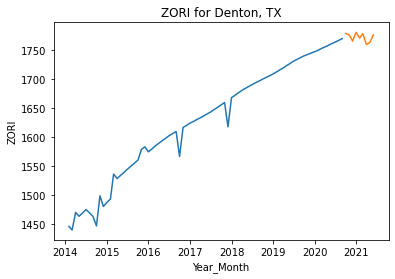

In [235]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual_county)
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = pred_county)
plt.title(f'ZORI for {county}, {state}');

In [84]:
# National prediction
df_pred_usa = df_pred.groupby(['Year', 'Month']).mean().reset_index()
df_pred_usa_MLR = df_pred_MLR.groupby(['Year', 'Month']).mean().reset_index()
df_pred_change_usa = df_pred_change.groupby(['Year', 'Month']).mean().reset_index()
df_pred_change_usa_MLR = df_pred_change_MLR.groupby(['Year', 'Month']).mean().reset_index()

In [85]:
actual_usa = zori.groupby(['Year', 'Month']).mean().reset_index()[['Year', 'Month', 'ZORI']]
actual_usa['Year_Month'] = actual_usa['Year'].map(str) + '_' + actual_usa['Month'].map(str)
actual_usa['Year_Month'] = pd.to_datetime(actual_usa['Year_Month'], format = '%Y_%m')
temp_date_usa = pd.to_datetime(df_pred_usa['Year'].map(str) + '_' + df_pred_usa['Month'].map(str), format = '%Y_%m')

In [86]:
pred_usa_MLR = regression.predict(df_pred_usa_MLR.iloc[:, 3:])
pred_usa_GBM = grid_search_gbm.predict(df_pred_usa.iloc[:, 3:])
pred_usa_RF = grid_search_forest.predict(df_pred_usa.iloc[:, 3:])
pred_change_usa_MLR = regression_change.predict(df_pred_change_usa_MLR.iloc[:, 3:])
pred_change_usa_MLR = np.array(actual_usa[actual_usa['Year_Month'].isin(temp_date_usa.map(lambda date:\
                               date - relativedelta(months = 12)))]['ZORI']) * np.array((1 + pred_change_usa_MLR))
pred_change_usa_GBM = grid_search_gbm_change.predict(df_pred_change_usa.iloc[:, 3:])
pred_change_usa_GBM = np.array(actual_usa[actual_usa['Year_Month'].isin(temp_date_usa.map(lambda date:\
                               date - relativedelta(months = 12)))]['ZORI']) * np.array((1 + pred_change_usa_GBM))
pred_change_usa_RF = grid_search_forest_change.predict(df_pred_change_usa.iloc[:, 3:])
pred_change_usa_RF = np.array(actual_usa[actual_usa['Year_Month'].isin(temp_date_usa.map(lambda date:\
                               date - relativedelta(months = 12)))]['ZORI']) * np.array((1 + pred_change_usa_RF))

pred_usa = pd.DataFrame({'Year_Month': temp_date_usa,
                         'ZORI': (pred_usa_MLR + pred_usa_GBM + pred_usa_RF + pred_change_usa_MLR + pred_change_usa_GBM +
                                  pred_change_usa_RF) / 6})

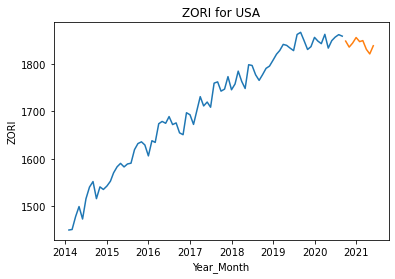

In [87]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual_usa)
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = pred_usa)
plt.title(f'ZORI for USA');